# Techbros - AI Engineer Assignment

Face recognition use case to detect people wearing mask or not using ResNet50. Then to goal is to convert the model into ONNX and test for detection.

Masks play a crucial role in protecting the health of individuals against respiratory diseases, as is one of the few precautions available for COVID-19 in the absence of immunization. 

## Import Library

In [1]:
# install library needed
!pip install -q kaggle
!pip install torch-summary
!pip install tqdm
!pip install split-folders

In [167]:
# import all the library needed
import urllib
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import ImageFolder
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset, Subset
from torchsummary import summary
from PIL import Image
from sklearn.model_selection import train_test_split

import os
import random
import xml.etree.ElementTree as ET
import time
import glob
import requests
import splitfolders
import warnings
from re import search
from tqdm import tqdm
from google.colab import files
import copy

warnings.filterwarnings('ignore') # To ignore the unwanted warning messages

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cpu')

In [3]:
# define base path
base_path = '/content/drive/MyDrive/Challenges/Techbros/'

# path of face mask dataset directory
dataset_path = base_path + 'datasets/data'

# path of face mask dataset directory
split_dataset_path = base_path + 'datasets/split'

# path of models saved
model_path = base_path + 'models'

# mount our google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Hyperparameter

In [4]:
num_classes = 2
batch_size = 4
num_epochs = 5
num_workers = 0
crop_size = 42

## Preprocessing

### Dataset Gathering

Data set consists of 7553 RGB images in 2 folders as withmask and withoutmask. Images are named as label withmask and withoutmask. Images of faces with mask are 3725 and images of faces without mask are 3828. Data source from https://www.kaggle.com/omkargurav/face-mask-dataset

The classes are:
- With mask: 3725 Images
- Without mask: 3828 Images

In [ ]:
# upload kaggle.json
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"imamkusniadi","key":"5d8faff39de90493cacc41163e9cbb26"}'}

In [ ]:
# make directory and change permission
!mkdir -p ~/.kaggle && cp kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json && ls ~/.kaggle

kaggle.json


In [ ]:
# download the dataset
!kaggle datasets download -d omkargurav/face-mask-dataset

 99% 162M/163M [00:08<00:00, 15.0MB/s]
100% 163M/163M [00:08<00:00, 20.4MB/s]


In [ ]:
!unzip face-mask-dataset.zip -d /content/drive/MyDrive/Challenges/Techbros/datasets/

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/Challenges/Techbros/datasets/data/with_mask/with_mask_3297.jpg  
  inflating: /content/drive/MyDrive/Challenges/Techbros/datasets/data/with_mask/with_mask_3298.jpg  
  inflating: /content/drive/MyDrive/Challenges/Techbros/datasets/data/with_mask/with_mask_3299.jpg  
  inflating: /content/drive/MyDrive/Challenges/Techbros/datasets/data/with_mask/with_mask_33.jpg  
  inflating: /content/drive/MyDrive/Challenges/Techbros/datasets/data/with_mask/with_mask_330.jpg  
  inflating: /content/drive/MyDrive/Challenges/Techbros/datasets/data/with_mask/with_mask_3300.jpg  
  inflating: /content/drive/MyDrive/Challenges/Techbros/datasets/data/with_mask/with_mask_3301.jpg  
  inflating: /content/drive/MyDrive/Challenges/Techbros/datasets/data/with_mask/with_mask_3302.jpg  
  inflating: /content/drive/MyDrive/Challenges/Techbros/datasets/data/with_mask/with_mask_3303.jpg  
  inflating: /content/drive/MyDrive/Challen

### Dataset Exploration

Count total of dataset and get sample data

In [5]:
# check total of data and sampling data
def count_data_sampling(path = dataset_path):
  images = []
  count_path = 0
  for dir in os.listdir(path):
    count_sub = 0
    sub = glob.glob(os.path.join(path, dir) + '/*')
    for file in sub:
      if count_sub < 6:
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        images.append([image, dir])

      count_sub += 1
      count_path += 1

    print("{} : {}".format(dir, count_sub))

  
  random.shuffle(images)
  random.shuffle(images)

  print("-"*30)
  print("total : {}\n".format(count_path))

  rows = 3
  plt.figure(figsize=(10,10))
  for i in range(12):
      plt.subplot(rows,4,i+1)
      plt.title("{}".format(images[i][1]))
      plt.imshow(images[i][0])
      plt.grid(True)

without_mask : 3828
with_mask : 3725
------------------------------
total : 7553



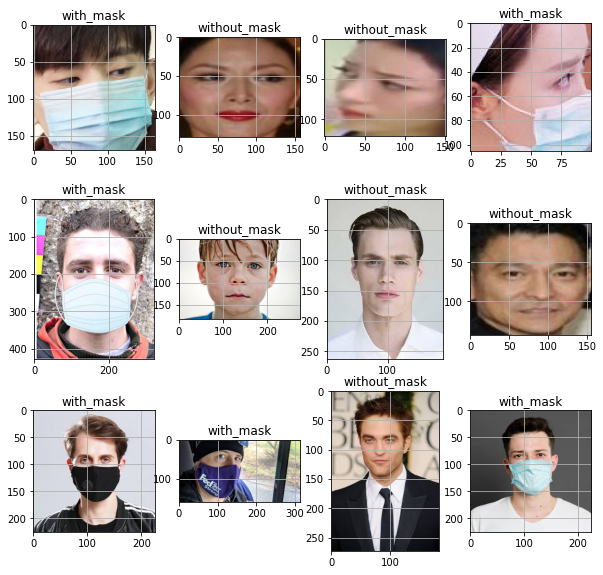

In [6]:
# check total dataset every label
count_data_sampling(dataset_path)

In [ ]:
# split dataset with 8:2 ratio 
splitfolders.ratio(
    dataset_path, 
    split_dataset_path, 
    seed=1, 
    ratio=(.8, .2)
)

Copying files: 7553 files [30:06,  4.18 files/s]


### Dataset Dataloader

In [12]:
# define mean and std
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

In [7]:
# transform dataset
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

image_datasets = {x: ImageFolder(os.path.join(split_dataset_path, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=num_workers) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# check available class name
class_names = image_datasets['train'].classes
print(class_names)

['with_mask', 'without_mask']


In [8]:
# check the number of datasets
train_length = len(image_datasets['train'])
val_length = len(image_datasets['val'])

print("Jumlah Data Train : {}".format(train_length))
print("Jumlah Data Validasi : {}".format(val_length))

Jumlah Data Train : 6042
Jumlah Data Validasi : 1511


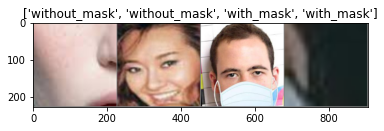

In [9]:
# check batch of training data
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

# get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [11]:
# get class index
image_datasets['train'].class_to_idx

{'with_mask': 0, 'without_mask': 1}

## Model

### RestNet50

In [7]:
def RestNet50(num_classes = num_classes):
    # Load a pretrained model and reset final fully connected layer.
    model = models.resnet50(pretrained=True)
    num_ftrs = model.fc.in_features
    # Here the size of each output sample is set to 2.
    # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
    model.fc = nn.Linear(num_ftrs, num_classes)

    return model

model = RestNet50()
summary(model)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─Bottleneck: 2-1                   --
|    |    └─Conv2d: 3-1                  4,096
|    |    └─BatchNorm2d: 3-2             128
|    |    └─Conv2d: 3-3                  36,864
|    |    └─BatchNorm2d: 3-4             128
|    |    └─Conv2d: 3-5                  16,384
|    |    └─BatchNorm2d: 3-6             512
|    |    └─ReLU: 3-7                    --
|    |    └─Sequential: 3-8              16,896
|    └─Bottleneck: 2-2                   --
|    |    └─Conv2d: 3-9                  16,384
|    |    └─BatchNorm2d: 3-10            128
|    |    └─Conv2d: 3-11                 36,864
|    |    └─BatchNorm2d: 3-12            128
|    |    └─Conv2d: 3-13                 16,384
|    |    └─BatchNorm2d: 3-14      

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─Bottleneck: 2-1                   --
|    |    └─Conv2d: 3-1                  4,096
|    |    └─BatchNorm2d: 3-2             128
|    |    └─Conv2d: 3-3                  36,864
|    |    └─BatchNorm2d: 3-4             128
|    |    └─Conv2d: 3-5                  16,384
|    |    └─BatchNorm2d: 3-6             512
|    |    └─ReLU: 3-7                    --
|    |    └─Sequential: 3-8              16,896
|    └─Bottleneck: 2-2                   --
|    |    └─Conv2d: 3-9                  16,384
|    |    └─BatchNorm2d: 3-10            128
|    |    └─Conv2d: 3-11                 36,864
|    |    └─BatchNorm2d: 3-12            128
|    |    └─Conv2d: 3-13                 16,384
|    |    └─BatchNorm2d: 3-14      

### Fast R-CNN RestNet50

In [5]:
def FastRCNN(num_classes = num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

model = FastRCNN()
summary(model)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

Layer (type:depth-idx)                   Param #
├─GeneralizedRCNNTransform: 1-1          --
├─BackboneWithFPN: 1-2                   --
|    └─IntermediateLayerGetter: 2-1      --
|    |    └─Conv2d: 3-1                  (9,408)
|    |    └─FrozenBatchNorm2d: 3-2       --
|    |    └─ReLU: 3-3                    --
|    |    └─MaxPool2d: 3-4               --
|    |    └─Sequential: 3-5              (212,992)
|    |    └─Sequential: 3-6              1,212,416
|    |    └─Sequential: 3-7              7,077,888
|    |    └─Sequential: 3-8              14,942,208
|    └─FeaturePyramidNetwork: 2-2        --
|    |    └─ModuleList: 3-9              984,064
|    |    └─ModuleList: 3-10             2,360,320
|    |    └─LastLevelMaxPool: 3-11       --
├─RegionProposalNetwork: 1-3             --
|    └─AnchorGenerator: 2-3              --
|    └─RPNHead: 2-4                      --
|    |    └─Conv2d: 3-12                 590,080
|    |    └─Conv2d: 3-13                 771
|    |    └─Conv2d:

Layer (type:depth-idx)                   Param #
├─GeneralizedRCNNTransform: 1-1          --
├─BackboneWithFPN: 1-2                   --
|    └─IntermediateLayerGetter: 2-1      --
|    |    └─Conv2d: 3-1                  (9,408)
|    |    └─FrozenBatchNorm2d: 3-2       --
|    |    └─ReLU: 3-3                    --
|    |    └─MaxPool2d: 3-4               --
|    |    └─Sequential: 3-5              (212,992)
|    |    └─Sequential: 3-6              1,212,416
|    |    └─Sequential: 3-7              7,077,888
|    |    └─Sequential: 3-8              14,942,208
|    └─FeaturePyramidNetwork: 2-2        --
|    |    └─ModuleList: 3-9              984,064
|    |    └─ModuleList: 3-10             2,360,320
|    |    └─LastLevelMaxPool: 3-11       --
├─RegionProposalNetwork: 1-3             --
|    └─AnchorGenerator: 2-3              --
|    └─RPNHead: 2-4                      --
|    |    └─Conv2d: 3-12                 590,080
|    |    └─Conv2d: 3-13                 771
|    |    └─Conv2d:

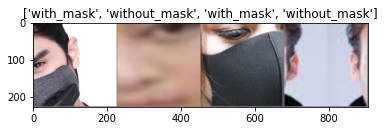

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
# load dataset into tensor format
class FaceMaskDataset(Dataset):
    def __init__(self, image_list, transform = None):
        self.image_list = image_list
        self.transform = transform
       
    def __getitem__(self, idx):
        """
        Load the image
        """
        img_path = self.image_list[idx]
        img = Image.open(img_path).convert('RGB')
        # img = transforms.ToTensor()(img)

        if self.transform is not None:
            img = self.transform(img)

        """
        build the target dict
        """
        if search("with_mask", img_path) == None:
          labels = 0 # without mask
        else:
          labels = 1 # with mask

        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        target = {}
        
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        return img, target
                    
    def __len__(self):
        return len(self.image_list)

# create list data file in array
def dataset_list(path):
    datasets = []
    for dir in os.listdir(path):
      sub = glob.glob(os.path.join(path, dir) + '/*')
      for file in sub:
        datasets.append(file)

    return datasets

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomCrop(crop_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.TenCrop(crop_size),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops]))
])

train_list = dataset_list(os.path.join(split_dataset_path, 'train'))
train_set = FaceMaskDataset(train_list, train_transform)
trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

val_list = dataset_list(os.path.join(split_dataset_path, 'val'))
val_set = FaceMaskDataset(val_list, test_transform)
valloader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
# check dataset shape
inputs, target = next(iter(valloader))
print(inputs.shape)

torch.Size([4, 10, 3, 42, 42])


In [ ]:
t = np.ones((crop_size, crop_size, 3))
t = transforms.ToTensor()(t)
t.shape

torch.Size([3, 42, 42])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
#### Finetuning the convnet ####
# Load a pretrained model and reset final fully connected layer.

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.3751 Acc: 0.8241
val Loss: 0.0541 Acc: 0.9894
Epoch 1/24
----------
train Loss: 0.3178 Acc: 0.8618
val Loss: 0.0331 Acc: 0.9960
Epoch 2/24
----------
train Loss: 0.2771 Acc: 0.8779
val Loss: 0.0268 Acc: 0.9967
Epoch 3/24
----------
train Loss: 0.2578 Acc: 0.8926
val Loss: 0.0247 Acc: 0.9960
Epoch 4/24
----------
train Loss: 0.2427 Acc: 0.8966
val Loss: 0.0246 Acc: 0.9967
Epoch 5/24
----------
train Loss: 0.2428 Acc: 0.8979
val Loss: 0.0219 Acc: 0.9960
Epoch 6/24
----------
train Loss: 0.2394 Acc: 0.8987
val Loss: 0.0224 Acc: 0.9967
Epoch 7/24
----------
train Loss: 0.2399 Acc: 0.8999
val Loss: 0.0237 Acc: 0.9960
Epoch 8/24
----------
train Loss: 0.2187 Acc: 0.9121
val Loss: 0.0205 Acc: 0.9980
Epoch 9/24
----------
train Loss: 0.2286 Acc: 0.8962
val Loss: 0.0223 Acc: 0.9974
Epoch 10/24
----------
train Loss: 0.2277 Acc: 0.9035
val Loss: 0.0224 Acc: 0.9974
Epoch 11/24
----------


## Training

In [13]:
def Validate(model, criterion):
    accuracy = 0
    test_loss = 0
    model.eval() # Evaluation mode
    with torch.no_grad():
        for images, labels in dataloaders['val']:
            
            images = images.to(device)
            labels = labels.to(device)

            output = model.forward(images)
            test_loss += criterion(output, labels).item()

            # Take exponential to get log softmax probibilities
            probs = torch.exp(output)

            # highest probability is the predicted class
            # compare with true label
            correct_predictions = (labels.data == probs.max(1)[1])

            # Turn ByteTensor into np_array to calculate mean
            accuracy += np.array(correct_predictions.cpu()).mean()
    
    model.train() # Switch training mode back on
    
    return test_loss/len(dataloaders['val']), accuracy/len(dataloaders['val'])

In [14]:
def Train(model, criterion, optimizer, scheduler, num_epochs = num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                model.class_to_idx = image_datasets['train'].class_to_idx
                print('\nSaving..')
                print("Best val Acc: %0.3f\n" % best_acc)
                state = {
                    'class_to_idx': model.class_to_idx,
                    'state_dict': model.state_dict() if use_cuda else model,
                    'acc': best_acc,
                    'epoch': epoch,
                }
                if not os.path.isdir(model_path):
                    os.mkdir(model_path)
                torch.save(state, os.path.join(model_path, 'best_model.pth'))
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Training RestNet50

In [15]:
model = RestNet50().to(device) # inisialisasi model
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [16]:
# start training
model = Train(model, criterion, optimizer, step_lr_scheduler, num_epochs=num_epochs)

Epoch 0/4
----------
train Loss: 0.3587 Acc: 0.8401
val Loss: 0.0484 Acc: 0.9921

Saving..
Best val Acc: 0.992


Epoch 1/4
----------
train Loss: 0.2706 Acc: 0.8870
val Loss: 0.0296 Acc: 0.9960

Saving..
Best val Acc: 0.996


Epoch 2/4
----------
train Loss: 0.2637 Acc: 0.8881
val Loss: 0.0247 Acc: 0.9940

Epoch 3/4
----------
train Loss: 0.2166 Acc: 0.9096
val Loss: 0.0210 Acc: 0.9967

Saving..
Best val Acc: 0.997


Epoch 4/4
----------
train Loss: 0.1945 Acc: 0.9181
val Loss: 0.0159 Acc: 0.9980

Saving..
Best val Acc: 0.998


Training complete in 31m 32s
Best val Acc: 0.998015


In [17]:
# check the test loss and accuracy of the trained network
test_loss, accuracy = Validate(model, criterion)
print("Network preformance on test dataset ...")
print("Accuracy on test dataset: %{:.1f}".format(accuracy*100))

Network preformance on test dataset ...
Accuracy on test dataset: %99.8


## Prediction

### Load Save Checkpoint

In [137]:
# helper function to load model
def load_model(path):
    # checkpoint = torch.load(path) # when using GPU
    checkpoint = torch.load(path, map_location=torch.device('cpu')) # when using CPU

    # For loading, use the same build_network function used to make saved model's network
    model = RestNet50().to(device)
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    
    return model
    
loaded_model = load_model(os.path.join(model_path, 'best_model.pth'))
print("Model loaded ...")

Model loaded ...


In [133]:
# helper function for single image prediction
def predict(model, image, topk=1):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    if topk < 1:
        topk = 1
        
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    model.eval()
    
    # Transform the np_array image
    # before running through model
    data_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    tensor_img = data_transforms(image)
    # Note: model expects an 1D array of tensors of size (3, 244, 244)
    # so that's why I'm putting the result of process_image()
    # in brackets before passing into FloatTensor()
    # in other words, model expects a tensor of size (1, 3, 244, 244)
    # you coud also use `tensor_img = tensor_img.unsqueeze(0)`
    tensor_img = tensor_img.unsqueeze(0).to(device)
    
    result = model(tensor_img).topk(topk)
    print(model(tensor_img))
    
    # Take the natural exponent of each probablility
    # to undo the natural log from the NLLLoss criterion
    probs = torch.exp(result[0].data).cpu().numpy()[0]
    # .cpu() to take the tensor off gpu
    # so it can be turned into a np_array
    # .cpu() should not be called if predicting on a cpu already
    idxs = result[1].data.cpu().numpy()[0]
    
    return(probs, idxs)

### Class Prediction

In [134]:
url = 'https://assets.weforum.org/article/image/yv_SffigotevWgXLOTBsbybWzDlztGjjJM1mDWSqV8c.jpg'
test_img = Image.open(requests.get(url, stream=True).raw).convert('RGB')
probs, classes = predict(loaded_model, test_img)

print(probs)
print(classes)

tensor([[-2.0472,  2.3590]], grad_fn=<AddmmBackward>)
[10.579845]
[1]


### Sanity Check

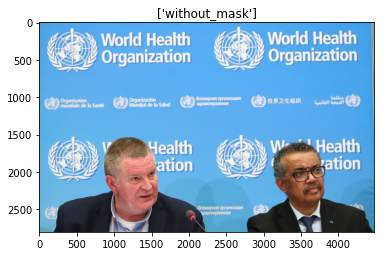

Prediction took 288.6085510253906 milliseconds


In [119]:
# load image from URL
url = 'https://assets.weforum.org/article/image/yv_SffigotevWgXLOTBsbybWzDlztGjjJM1mDWSqV8c.jpg'
test_img = Image.open(requests.get(url, stream=True).raw).convert('RGB')

start_time = time.time()
# Get the probabilties and indices from passing the image through the model
probs, idxs = predict(loaded_model, test_img)
end_time = time.time()

# Swap the keys and values in class_to_idx so that
# indices can be mapped to original classes in dataset
idx_to_class = {v: k for k, v in loaded_model.class_to_idx.items()}

# Map the classes to flower category lables                              
names = list(map(lambda x: str(idx_to_class[x]), idxs))

plt.imshow(test_img)
plt.title(names)
plt.show()
print(f"Prediction took {(end_time-start_time) * 1000} milliseconds")

## Implement ONNX

### Convert Into ONNX

In [138]:
# set the device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('running on device ' + str(device))

running on device cpu


In [139]:
# load the model checkpoint
model = loaded_model
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [140]:
# create dumy input
dummy_input = torch.randn(1, 3, 224, 224)

In [141]:
# format output model path
output_path = model_path + 'resnet5-model.onnx'

# export the model
input_names = [ "input_0" ]
output_names = [ "output_0" ]

print('exporting model to ONNX...')
torch.onnx.export(model, dummy_input, output_path, verbose=False, input_names=input_names, output_names=output_names, export_params=True,)
print('model exported to:  {:s}'.format(output_path))

exporting model to ONNX...
model exported to:  /content/drive/MyDrive/Challenges/Techbros/modelsresnet5-model.onnx


### ONNX Model Validate

In [27]:
!pip install onnx

In [29]:
import onnx
import sys

In [142]:
# Load the ONNX model
model = onnx.load(output_path)

In [143]:
# Print a human readable representation of the graph
print('Network Graph:')
print(onnx.helper.printable_graph(model.graph))
print('')

# Print model metadata
print('ONNX version:      ' + onnx.__version__)
print('IR version:        {:d}'.format(model.ir_version))
print('Producer name:     ' + model.producer_name)
print('Producer version:  ' + model.producer_version)
print('Model version:     {:d}'.format(model.model_version))
print('')

# Check that the IR is well formed
print('Checking model IR...')
onnx.checker.check_model(model)
print('The model was checked successfully!')

Network Graph:
graph torch-jit-export (
  %input_0[FLOAT, 1x3x224x224]
) initializers (
  %fc.weight[FLOAT, 2x2048]
  %fc.bias[FLOAT, 2]
  %497[FLOAT, 64x3x7x7]
  %498[FLOAT, 64]
  %500[FLOAT, 64x64x1x1]
  %501[FLOAT, 64]
  %503[FLOAT, 64x64x3x3]
  %504[FLOAT, 64]
  %506[FLOAT, 256x64x1x1]
  %507[FLOAT, 256]
  %509[FLOAT, 256x64x1x1]
  %510[FLOAT, 256]
  %512[FLOAT, 64x256x1x1]
  %513[FLOAT, 64]
  %515[FLOAT, 64x64x3x3]
  %516[FLOAT, 64]
  %518[FLOAT, 256x64x1x1]
  %519[FLOAT, 256]
  %521[FLOAT, 64x256x1x1]
  %522[FLOAT, 64]
  %524[FLOAT, 64x64x3x3]
  %525[FLOAT, 64]
  %527[FLOAT, 256x64x1x1]
  %528[FLOAT, 256]
  %530[FLOAT, 128x256x1x1]
  %531[FLOAT, 128]
  %533[FLOAT, 128x128x3x3]
  %534[FLOAT, 128]
  %536[FLOAT, 512x128x1x1]
  %537[FLOAT, 512]
  %539[FLOAT, 512x256x1x1]
  %540[FLOAT, 512]
  %542[FLOAT, 128x512x1x1]
  %543[FLOAT, 128]
  %545[FLOAT, 128x128x3x3]
  %546[FLOAT, 128]
  %548[FLOAT, 512x128x1x1]
  %549[FLOAT, 512]
  %551[FLOAT, 128x512x1x1]
  %552[FLOAT, 128]
  %554[FLOAT,

### ONNX Model Prediction

In [32]:
!pip install onnxruntime

     |████████████████████████████████| 4.8 MB 4.9 MB/s 


In [170]:
import onnxruntime as onnxrt
import json
import numpy
import time

In [163]:
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

def onnx_predict(ort_session, image):
    '''
      Input:
        ort_Session: the onnx ort session
        image: image data in nummpy format
      Output:
        str: label prediction in clear text
        fload: time used
    '''
    # Transform the np_array image
    # before running through model
    data_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    tensor_img = data_transforms(image)
    # Note: model expects an 1D array of tensors of size (3, 244, 244)
    # so that's why I'm putting the result of process_image()
    # in brackets before passing into FloatTensor()
    # in other words, model expects a tensor of size (1, 3, 244, 244)
    # you coud also use `tensor_img = tensor_img.unsqueeze(0)`
    tensor_img = tensor_img.unsqueeze(0).to(device)

    start_time = time.time()
    # Get the probabilties and indices from passing the image through the model
    ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(tensor_img)}
    ort_outs = ort_session.run(None, ort_inputs)
    end_time = time.time()

    labels = ['with_mask', 'without_mask']
    prediction = int(np.argmax(np.array(ort_outs).squeeze(), axis=0))
    time_used = (end_time-start_time) * 1000
    
    return labels[prediction], time_used

with_mask


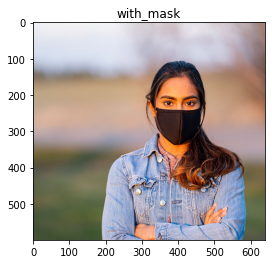

Prediction took 139.48917388916016 milliseconds


In [172]:
# start ort session
ort_session = onnxrt.InferenceSession(output_path)

# load the image
url = 'https://www.henryford.com/-/media/henry-ford-blog/images/mobile-interior-banner-images/2020/07/mask-myths.jpg'
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')

# start prediction
label, time_used = onnx_predict(ort_session, image)
print(label)

plt.imshow(image)
plt.title(label)
plt.show()
print(f"Prediction took {time_used} milliseconds")

**Conclusion PyTorch Model vs ONNX Model**

```shell
Prediction took 288.6085510253906 milliseconds - using PyTorch model
Prediction took 139.48917388916016 milliseconds - using ONNX model
```

Yang paling terlihat adalah waktu pemrosesan model yang telah dikonversi ke ONNX lebih cepat. Selain itu dari hal - hal yang telah dipelajari mengenai ONNX, terdapat beberapa keunggulan lain dari penggunaan ONNX ini diantaranya:

- Improvement in inference performance, inference time is considerably reduced.
- Reduced training time.
- Develop and train models in Python and deploy in C, C ++ or Java based applications.

## Face Recognition Implementation using ONNX + OpenCV

### Helper

In [184]:
import dlib
import math
face_detector = dlib.get_frontal_face_detector()

In [204]:
def evaluate(ort_session, cropped_face):
    """
    This function classifies the cropped  face on loading the trained model
    and returns the label value
    """
    # convert image to PIL
    image = Image.fromarray(cropped_face).convert('RGB')

    # Transform the np_array image
    # before running through model
    data_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    tensor_img = data_transforms(image)
    # Note: model expects an 1D array of tensors of size (3, 244, 244)
    # so that's why I'm putting the result of process_image()
    # in brackets before passing into FloatTensor()
    # in other words, model expects a tensor of size (1, 3, 244, 244)
    # you coud also use `tensor_img = tensor_img.unsqueeze(0)`
    tensor_img = tensor_img.unsqueeze(0).to(device)

    # Get the probabilties and indices from passing the image through the model
    ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(tensor_img)}
    ort_outs = ort_session.run(None, ort_inputs)

    labels = ['with_mask', 'without_mask']
    prediction = int(np.argmax(np.array(ort_outs).squeeze(), axis=0))
    return labels[prediction]

def get_boundingbox(face, width, height, scale=1.3, minsize=None):
    #Reference: https://github.com/ondyari/FaceForensics
    """
    Expects a dlib face to generate a quadratic bounding box.
    :param face: dlib face class
    :param width: frame width
    :param height: frame height
    :param scale: bounding box size multiplier to get a bigger face region
    :param minsize: set minimum bounding box size
    :return: x, y, bounding_box_size in opencv form
    """
    x1 = face.left() # Taking lines numbers around face
    y1 = face.top()
    x2 = face.right()
    y2 = face.bottom()
    size_bb = int(max(x2 - x1, y2 - y1) * scale) # scaling size of box to 1.3
    if minsize:
        if size_bb < minsize:
            size_bb = minsize
    center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2

    # Check for out of bounds, x-y top left corner
    x1 = max(int(center_x - size_bb // 2), 0)
    y1 = max(int(center_y - size_bb // 2), 0)
    # Check for too big bb size for given x, y
    size_bb = min(width - x1, size_bb)
    size_bb = min(height - y1, size_bb)

    return x1, y1, size_bb

def predict_image(ort_session, image_path):
    face_results = []
    total_with_mask = []
    total_without_mask = []

    image = cv2.imread(image_path, 1)
    faces = face_detector(image)
    height, width = image.shape[:2]

    # clone the original image so we can draw on it, then
    # display the name of the face part on the image
    clone = image.copy()

    print("Detection Results On Each Face")
    print("Total faces detected:", len(faces))

    for (i, rect) in enumerate(faces):
        try: # If in case face is not detected at any frame
            x, y, size = get_boundingbox(face=faces[i], width=width, height=height)
        except IndexError:
            pass
        
        cropped_face = image[y:y+size, x:x+size]
        label = evaluate(ort_session, cropped_face)

        if label == 'with_mask':
            total_with_mask.append(label)
            color = (0, 255, 0)
        else:
            total_without_mask.append(label)
            color = (0, 0, 255)

        # Get sample image detection
        face_rgb = cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB)
        face_rgb = cv2.resize(face_rgb, (299, 299))
        face_results.append([face_rgb,label])

        # Setting font
        font_face = cv2.FONT_HERSHEY_SIMPLEX # font settings
        thickness = 2
        font_scale = 1

        # Setting the bounding box on uncropped image
        x = rect.left()
        y = rect.top()
        w = rect.right() - x
        h = rect.bottom() - y
        # Putting the label values
        cv2.putText(clone, label, (x, y+h+30), 
                    font_face, font_scale,
                    color, thickness, 2)
        # Draw box over face
        cv2.rectangle(clone, (x, y), (x + w, y + h), color, 2)

    print("Total detected as with mask:", len(total_with_mask))
    print("Total detected as without mask:", len(total_without_mask))

    clone_rgb = cv2.cvtColor(clone, cv2.COLOR_BGR2RGB)
    plt.imshow(clone_rgb)

    rows = math.ceil(len(faces)/5)
    pading = math.ceil(len(faces)/2) + math.ceil(len(faces)/1.5)
    plt.figure(figsize=(16,pading))
    for i in range(len(face_results)):
        try:
            plt.subplot(rows,5,i+1)
            plt.title("{}".format(face_results[i][1]))
            plt.imshow(face_results[i][0])
        except:
            pass

### Load ORT Session

In [179]:
# start ort session
ort_session = onnxrt.InferenceSession(output_path)

### Make Prediction

Detection Results On Each Face
Total faces detected: 1
Total detected as with mask: 1
Total detected as without mask: 0


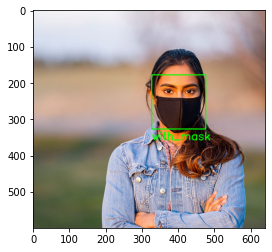

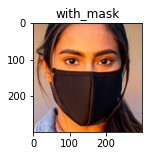

In [205]:
# with_mask: /content/drive/MyDrive/Challenges/Techbros/images/mask.jpg
# without_mask: /content/drive/MyDrive/Challenges/Techbros/images/nomask.png
# with_mask + without_mask: /content/drive/MyDrive/Challenges/Techbros/images/mask-nomask.png

predict_image(ort_session, '/content/drive/MyDrive/Challenges/Techbros/images/mask.jpg')

Detection Results On Each Face
Total faces detected: 5
Total detected as with mask: 0
Total detected as without mask: 5


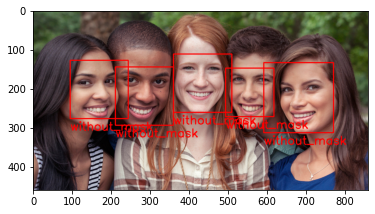

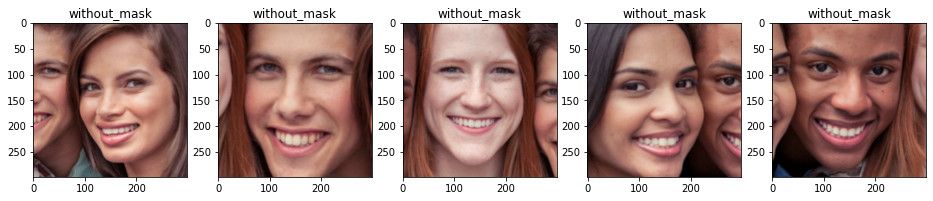

In [206]:
# with_mask: /content/drive/MyDrive/Challenges/Techbros/images/mask.jpg
# without_mask: /content/drive/MyDrive/Challenges/Techbros/images/nomask.png
# with_mask + without_mask: /content/drive/MyDrive/Challenges/Techbros/images/mask-nomask.png

predict_image(ort_session, '/content/drive/MyDrive/Challenges/Techbros/images/nomask.png')

Detection Results On Each Face
Total faces detected: 6
Total detected as with mask: 5
Total detected as without mask: 1


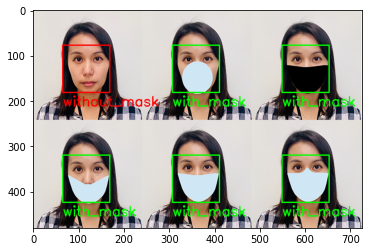

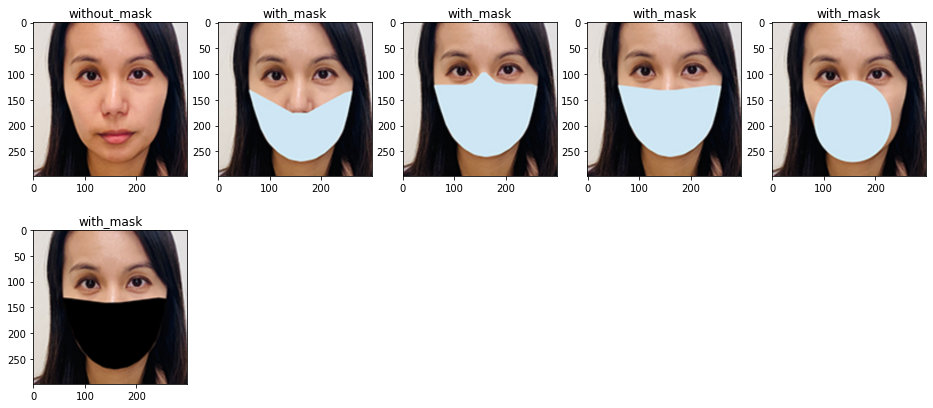

In [207]:
# with_mask: /content/drive/MyDrive/Challenges/Techbros/images/mask.jpg
# without_mask: /content/drive/MyDrive/Challenges/Techbros/images/nomask.png
# with_mask + without_mask: /content/drive/MyDrive/Challenges/Techbros/images/mask-nomask.png

predict_image(ort_session, '/content/drive/MyDrive/Challenges/Techbros/images/mask-nomask.png')